In [26]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", 200)

In [27]:
data = pd.read_pickle("train_data.pkl")
data.head()

,text,sentiment,normalized_text
0,"I`d have responded, if I were going",0,have responded were going
1,Sooo SAD I will miss you here in San Diego!!!,2,sooo sad will miss you here san diego
2,my boss is bullying me...,2,boss bullying
3,what interview! leave me alone,2,what interview leave alone
4,"Sons of ****, why couldn`t they put them on the releases we already bought",2,sons why couldn they put them the releases already bought


#### Simple Deep Learning Model with OHE (Binary) Features

In [28]:
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [29]:
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(64, input_shape=(n_words,), activation='relu', kernel_regularizer='l2'))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    
    # Output layer for multi-class classification
    model.add(Dense(3, activation='softmax'))  # 3 neurons for 3 classes (positive, negative, neutral)
    
    # compile network
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # summarize defined model
    model.summary()    
    plot_model(model, to_file='model1.png', show_shapes=True)
    return model

In [30]:
# evaluate a neural network model
def evaluate_model(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 5
    n_words = Xtest.shape[1]
    
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        
        # fit network
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        
        # evaluate
        _, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [31]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer() # num_words=1000
    tokenizer.fit_on_texts(lines)
    return tokenizer
# create the tokenizer
train_docs = data['normalized_text']
tokenizer = create_tokenizer(train_docs)
# encode data
X = tokenizer.texts_to_matrix(train_docs, mode='binary')
X.shape

(27481, 23843)

In [32]:
y = data['sentiment']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,  test_size=0.2,random_state=42) 
Xtrain.shape, Xtest.shape

((21984, 23843), (5497, 23843))

In [33]:
# define network
K.clear_session() 
n_words = Xtrain.shape[1]
model = define_model(n_words)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1526016   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1528195 (5.83 MB)
Trainable params: 1528195 (5.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
# fit network
checkpoint = ModelCheckpoint("BestModel.h5",
                             monitor="val_loss", 
                             mode="min",
                             save_best_only = True,
                             verbose=1)
callbacks = [checkpoint]

h = model.fit(Xtrain, ytrain, validation_split=0.1, callbacks = callbacks, batch_size=180, epochs=25, verbose=2)

Epoch 1/25

Epoch 1: val_loss improved from inf to 1.09050, saving model to BestModel.h5
110/110 - 4s - loss: 1.3351 - accuracy: 0.5856 - val_loss: 1.0905 - val_accuracy: 0.6553 - 4s/epoch - 37ms/step


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/25

Epoch 2: val_loss improved from 1.09050 to 0.98123, saving model to BestModel.h5
110/110 - 2s - loss: 1.0210 - accuracy: 0.6714 - val_loss: 0.9812 - val_accuracy: 0.6808 - 2s/epoch - 20ms/step
Epoch 3/25

Epoch 3: val_loss improved from 0.98123 to 0.94945, saving model to BestModel.h5
110/110 - 2s - loss: 0.9597 - accuracy: 0.6798 - val_loss: 0.9495 - val_accuracy: 0.6935 - 2s/epoch - 19ms/step
Epoch 4/25

Epoch 4: val_loss improved from 0.94945 to 0.93597, saving model to BestModel.h5
110/110 - 2s - loss: 0.9368 - accuracy: 0.6897 - val_loss: 0.9360 - val_accuracy: 0.6994 - 2s/epoch - 18ms/step
Epoch 5/25

Epoch 5: val_loss improved from 0.93597 to 0.92389, saving model to BestModel.h5
110/110 - 2s - loss: 0.9232 - accuracy: 0.6972 - val_loss: 0.9239 - val_accuracy: 0.6958 - 2s/epoch - 18ms/step
Epoch 6/25

Epoch 6: val_loss did not improve from 0.92389
110/110 - 2s - loss: 0.9101 - accuracy: 0.6994 - val_loss: 0.9292 - val_accuracy: 0.6880 - 2s/epoch - 21ms/step
Epoch 7/2

Text(0, 0.5, 'Loss Fn valaues')

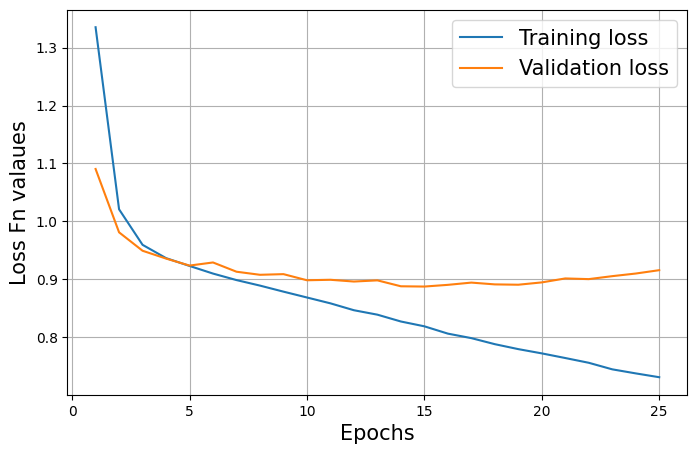

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(list(range(1,26)), h.history['loss'], label='Training loss')
plt.plot(list(range(1,26)), h.history['val_loss'], label='Validation loss')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss Fn valaues', fontsize=15)


Text(0, 0.5, 'Accuracy')

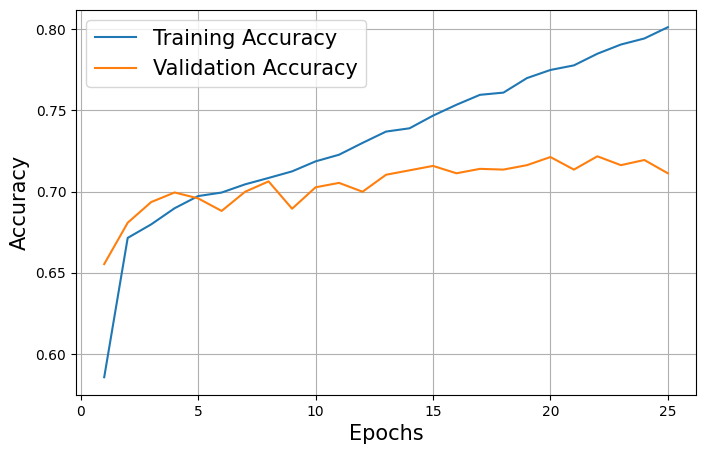

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(list(range(1,26)), h.history['accuracy'], label='Training Accuracy')
plt.plot(list(range(1,26)), h.history['val_accuracy'], label='Validation Accuracy')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

In [37]:
# evaluate the model ONCe on the test set
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 70.984173
